In [1]:
import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [2]:
import openpyxl
train_data = pd.read_excel("cases_2021_train_processed_2.xlsx")
test_data = pd.read_excel("cases_2021_test_processed_unlabelled_2.xlsx")

In [3]:
train_data.describe()

,age,latitude,longitude,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio
count,17212.000000,17212.00000,17212.000000,1.721200e+04,17212.000000,1.721200e+04,1.721200e+04,17212.000000,17212.000000
mean,37.917035,15.52814,87.779277,7.533620e+05,10575.751975,7.030148e+05,3.977138e+04,985.076567,1.331406
std,18.665858,5.67391,18.462448,2.946011e+05,5296.792015,2.749654e+05,8.719765e+04,527.183388,0.420566
min,0.000000,-34.92890,-123.100000,1.930000e+02,1.000000,1.830000e+02,1.000000e+00,0.771388,0.049685
25%,24.000000,12.82423,78.151640,7.472880e+05,12567.000000,6.037460e+05,1.587900e+04,681.949809,1.260476
50%,35.000000,13.12462,80.282520,8.866730e+05,12719.000000,8.580750e+05,1.587900e+04,1139.078325,1.434463
75%,51.000000,16.20000,86.399940,8.866730e+05,12719.000000,8.580750e+05,2.826700e+04,1139.078325,1.434463
max,99.000000,49.25000,153.400000,4.611392e+06,95052.000000,2.400727e+06,4.251829e+06,13943.072662,6.620495


<AxesSubplot:>

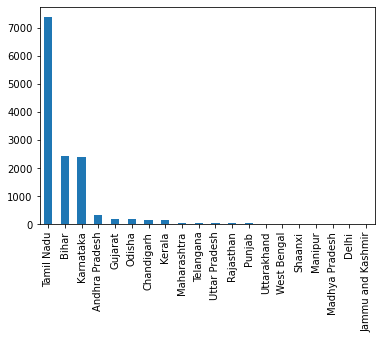

In [4]:
train_data['province'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar')

<AxesSubplot:>

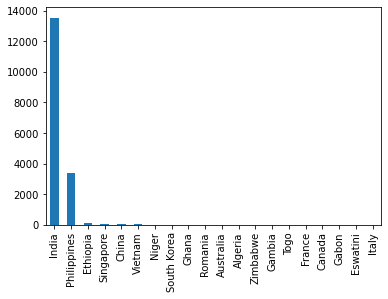

In [5]:
train_data['country'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar')

In [6]:
# train_data['Active'].hist()
scalar = StandardScaler()
scalar.fit_transform(train_data['Active'].values.reshape(-1, 1))

array([[-0.43799907],
       [ 1.03759968],
       [-0.27401052],
       ...,
       [-0.43799907],
       [-0.27401052],
       [ 1.03759968]])

# Data preprocess

In [7]:
class CustomEncoder(TransformerMixin):
   
    def __init__(self, col, ordering=None):
        self.col = col
        self.ordering = ordering

    def fit(self, *_):
        return self

    def create_ordering(self, df):
        s = df[self.col]
        s_list = s.dropna().unique()
        # print(s_list)
        s_list = sorted(s_list)
        s_dict = {item: k for k, item in enumerate(s_list)}
        return s_dict

    def transform(self, df):
        if df[self.col].isnull().sum() > 0:
            df[self.col] = df[self.col].fillna(df[self.col].mode()[0])
        if self.ordering is None:
            self.ordering = self.create_ordering(df)
        try:
            df[self.col] = df[self.col].map(lambda x: self.ordering[x])
        except KeyError:
            self.ordering = self.create_ordering(df)
            df[self.col] = df[self.col].map(lambda x: self.ordering[x])
        return df

In [8]:
class CustomStandardScarl(TransformerMixin):
   
    def __init__(self, col):
        self.col = col

    def fit(self, *_):
        return self

    def transform(self, df):
        sd = StandardScaler()
        df[self.col] = df[self.col]
        if isinstance(self.col, list):
            for _list_name in self.col:
                df[_list_name] = sd.fit_transform(
                    df[_list_name].values.reshape(-1, 1))
        else:
            df[self.col] = sd.fit_transform(df[self.col].values.reshape(-1, 1))
        return df

# Task 1.2 Mapping the features

In [9]:
# mapping privince
province_T = CustomEncoder(col='province')
# mapping contry
country_T = CustomEncoder(col='country')
# mapping sex
sex_T = CustomEncoder(col='sex')
# mapping chronic
chronic_T = CustomEncoder(col='chronic_disease_binary')
# mapping outcome_group
outcome_dict = {'deceased': 0, 'hospitalized': 1, 'nonhospitalized': 2}
outcome_T = CustomEncoder(col='outcome_group', ordering=outcome_dict)
# z-score
std = CustomStandardScarl(col=['age', 'latitude', 'longitude', 'Confirmed', 'Deaths',
                               'Recovered', 'Active', 'Incident_Rate', 'Case_Fatality_Ratio'])

In [10]:
train_data_process_pipeline = Pipeline([
    ('pt', province_T),
    ('ct', country_T),
    ('st', sex_T),
    ('ot', outcome_T),
    ('cht', chronic_T),
    ('std', std)
])

test_data_process_pipeline = Pipeline([
    ('pt', province_T),
    ('ct', country_T),
    ('st', sex_T),
    ('cht', chronic_T),
    ('std', std)
])

# Task 1.1 Feature selection

In [11]:
train_data = train_data.drop('date_confirmation', 1)
test_data_process_pipeline.fit_transform(test_data)
train_data_process_pipeline.fit_transform(train_data)
X = train_data.drop('outcome_group', 1).drop('province', 1).drop('latitude',1).drop('longitude',1).drop('country',1)
Y = train_data['outcome_group']
test_x = test_data.drop('date_confirmation', 1).drop('province', 1).drop('latitude',1).drop('longitude',1).drop('country',1)

D:\Miniconda\envs\cmpt459\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
D:\Miniconda\envs\cmpt459\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
D:\Miniconda\envs\cmpt459\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


# Task 1.3 Balancing the classes in the training dataset

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=99)

In [13]:
from collections import Counter
print('dataset shape %s' % Counter(y_train))
# ros = RandomOverSampler(random_state=42)
# ros = RandomUnderSampler(random_state=42)
ros = SMOTE(random_state=42)
x_train, y_train = ros.fit_resample(x_train, y_train)
X, Y = ros.fit_resample(X, Y)
print('Resampled dataset shape %s' % Counter(y_train))


dataset shape Counter({1: 10585, 2: 2389, 0: 795})
Resampled dataset shape Counter({2: 10585, 1: 10585, 0: 10585})


# Task 1.4 Building models and hyperparameter tuning

In [14]:
def get_model(model_name='dt'):
    if model_name == 'xgboost':
        # model = XGBClassifier() 
        model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
    elif model_name == 'knn':
        model = KNeighborsClassifier()
    elif model_name == 'svm':
        model = SVC()
    elif model_name == 'lgbm':
        model = lgb.LGBMClassifier()
    elif model_name =='dt':
        model = DecisionTreeClassifier()
    
    return model

In [15]:
def get_parameter(model_name='xgboost'):
    # search for hyperparameter
    if model_name == 'xgboost':
        learning_rate = [0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3] 
        gamma = [1, 0.1, 0.01, 0.001, 1e-4, 1e-5]
        grid = dict(learning_rate=learning_rate, gamma=gamma)
    elif model_name == 'svm':
        kernel = ['poly', 'rbf', 'sigmoid', 'precomputed']
        gamma = [1, 0.1, 0.01, 0.001, 1e-4, 1e-5]
        grid = dict(kernel=kernel, gamma=gamma)
    elif model_name == 'knn':
        n_neighbors = [5, 6, 7, 8, 9, 10]
        algorithm = ['ball_tree', 'kd_tree', 'brute']
        grid = dict(n_neighbors=n_neighbors, algorithm=algorithm)
    elif model_name == 'lgbm':
        # learning_rate=[0.1]
        # # min_child_samples=[20000]
        # # objective=['cross_entropy']
        # # importance_type=['gain']
        # # class_weight=['balanced']
        # # boosting_type=['gbdt']
        # n_estimators=[20]
        # silent=[True]
        # n_jobs=[1]
        # random_state=[0]
        learning_rate = [0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3] 
        lambda_l1 = [1, 0.1, 0.01, 0.001, 1e-4, 1e-5]
        # random_state=[666]
        max_depth = [5]
        # learning_rate = [0.3]
        # lambda_l1 = [1]
        # max_depth = [5]
        # # num_leaves =[0,1,2,3,4,5,6,7,8,9,10,16]
        # num_leaves = [5, 6, 7, 12, 13, 14, 15, 28, 29, 30, 31]
        # subsample = [0.8, 0.9, 1.0]
        # colsample_bytree = [0.8, 0.9, 1.0]
        # n_estimators = [20]
        grid = dict(learning_rate=learning_rate, lambda_l1=lambda_l1, max_depth=max_depth)
        # grid = dict(learning_rate=learning_rate, lambda_l1=lambda_l1,random_state=random_state)
        # grid = dict(max_depth=max_depth)
    elif model_name == 'dt':
        min_samples_leaf = [3,4,5,6, 8]  
        random_state = [10, 20, 30, 40] 
        criterion = ['gini', 'entropy']
        max_depth = [2,4,8,10,12,14,16,32]
        grid = dict(min_samples_leaf=min_samples_leaf, random_state=random_state, criterion = criterion, max_depth = max_depth)

    return grid

In [16]:
def main(model_name='dt'):
    
    param_grid = get_parameter(model_name)
   
    model = get_model(model_name)
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=99)
    
    kflod = StratifiedKFold(n_splits=10, shuffle=True, random_state=99) 
    # grid search
    grid_search = GridSearchCV(
        model, param_grid, scoring='f1_macro', n_jobs=-1, cv=kflod, verbose=3)
    # get the result
    grid_result = grid_search.fit(x_train, y_train) 
    pd.DataFrame(grid_result.cv_results_).to_csv(f'{model_name}.csv', mode='a')
    y_predict = grid_search.predict(x_test)

    print(f'model_name: {model_name}')
    print('f1_macro: ', f1_score(y_predict, y_test, average='macro'))
    print('f1 on \'deceased\': ', f1_score(y_predict, y_test, average=None)[0])
    print('acc: ', accuracy_score(y_predict, y_test))


### Test each model

In [17]:
# main(model_name='knn')

In [18]:
main(model_name='dt')

In [19]:
#main(model_name='xgboost')

Fitting 10 folds for each of 54 candidates, totalling 540 fits


D:\Miniconda\envs\cmpt459\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:44:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model_name: xgboost
f1_macro:  0.8681252765510491
f1 on 'deceased':  0.8154443007574359
acc:  0.8679672750157331


In [20]:
# main(model_name='svm')

In [21]:
# main(model_name='lgbm')

# 1.7 Prediction on the test set

In [22]:
def create_submission_file(y_preds, file_name): 
    with open(file_name, 'w',newline='') as csvfile: 
        wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL) 
        wr.writerow(["Id", "Prediction"]) 
        for i, pred in enumerate(y_preds): 
            wr.writerow([str(i), str(pred)]) 
    print(f"{file_name} done!")

In [23]:
model_name = 'dt'
# model = XGBClassifier(tree_method='gpu_hist', gpu_id=0, learning_rate=0.2, gamma=0.001)
# model = XGBClassifier(tree_method='gpu_hist', gpu_id=0, learning_rate=0.2, gamma=0.001)
# model = KNeighborsClassifier(n_neighbors=10,algorithm ='ball_tree')
# model = lgb.LGBMClassifier(learning_rate= 0.2,lambda_l1=1,)
model.fit(X, Y)
y_preds = model.predict(test_x)
create_submission_file(y_preds, f"submission_{model_name}.csv")

D:\Miniconda\envs\cmpt459\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:44:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
submission_xgboost.csv done!
